## Inicjalizacja środowiska programistycznego

In [1]:
#Color printing
from termcolor import colored

#General data operations library
import math, string, glob
from datetime import datetime
import numpy as np
import functools

#The tensorflow library
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

import tensorflow  as tf
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import logging
tf.get_logger().setLevel(logging.ERROR)

#Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

# import os
# os.chdir("/scratch_hdd/akalinow/Zajecia/2023-2024/Lato/Uczenie_maszynowe_2/UczenieMaszynoweII/PL/")

#append path with python modules
import importlib
import sys
# sys.path.append("../modules")

#Private functions
import plotting_functions as plf
importlib.reload(plf);

#Hide GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the second GPU
  try:
    tf.config.set_visible_devices(gpus[1], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

IndexError: list index out of range

<br/><br/>
<br/><br/>

<h1 align="center">
 Uczenie maszynowe II
</h1>

<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>

<h1 align="right">
Artur Kalinowski <br>
Uniwersytet Warszawski <br>
Wydział Fizyki <br>    
</h1>

## Komórki rekurencyjne - jednostki w których wartość wyjściowa jest podawana z powrotem na wejście.
Wartości wyjściowe i wejściowe są obliczane w krokach "czasowych".
Wyjście z poprzedniego kroku, `i-1`, jest podawane na wejście w aktualnym kroku, `i`:

![image.png](attachment:051b6b2e-295b-4ef2-a042-f9ac3b62654f.png)

Stan neuronu w kroku `i` jest nazywany zwykle stanem ukrytym, `ang. hidden` i nie musi być on tożsamy z wartością wyjściową neuronu.
![image.png](attachment:a3934ea2-5543-4f3f-b70b-7fbca37e2efc.png)

Standardowo komórki RNN przetwarzają sekwencje:

![image.png](attachment:873b5f22-7cd8-4f48-8c3d-06f6a3870e42.png)

Warstwa zawierająca najprostszy wariant, **bez dodatkowego mieszania składowych stanu ukrytego,**  komórki rekurencyjnej, ang. `Recurrent Neural Network cell, RNN cell`
jest zaimplementowana w interfejsie użytkownika Keras jako

```Python
tf.keras.layers.SimpleRNN(
    units,                              # liczba neuronów
    activation='tanh',                  # funkcja aktywacji. W RNN zwykle używa się tanh(x)
    use_bias=True,                      # czy warstwa ma używać wyrazów wolnych?
    recurrent_initializer='orthogonal', # inicjalizacja wag mieszających składowe stanu ukrytego
    recurrent_regularizer=None,         # regularyzacja wag mieszających składowe stanu ukrytego
    dropout=0.0,                        # ułamek losowo zerowanych składowych danych wejściowych
    recurrent_dropout=0.0,              # ułamek losowo zerowanych składowych stanu ukrytego
    return_sequences=False,             # czy warstwa ma zwracać sekwencję wartości w kolejnych krokach?
    return_state=False,                 # czy warstwa ma zwracać stan ukryty?
    go_backwards=False,                 # czy warstwa ma przetwarzać sekwencję w odwrotnej kolejności?
)
```

In [2]:
batchSize = 1
nTimeSteps = 3
inputDimension = 2
outputDimension = 2

input = np.random.random((batchSize, nTimeSteps, inputDimension))
simple_rnn = tf.keras.layers.SimpleRNN(outputDimension)
output = simple_rnn(input)
print(colored("RNN cell output:","blue"), output)

simple_rnn = tf.keras.layers.SimpleRNN(inputDimension,
                                       return_sequences=True,
                                       return_state=True)
output = simple_rnn(input)
print(colored("RNN cell output:","blue"), output)

RNN cell output: tf.Tensor([[ 0.7094907  -0.05420052]], shape=(1, 2), dtype=float32)
RNN cell output: (<tf.Tensor: shape=(1, 3, 2), dtype=float32, numpy=
array([[[0.11956878, 0.37619233],
        [0.340538  , 0.17476183],
        [0.39040244, 0.273892  ]]], dtype=float32)>, <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.39040244, 0.273892  ]], dtype=float32)>)


Badanie działania komórki RNN.

**Proszę:**

* przygotować dane wejściowe dla warstwy RNN:
    * jedna paczka
    * sto kroków czasowych
    * kolejne liczby całkowite w każdym kroku: `(0)`, `(1)` itd.

 * wypisać na ekran dane dla pierwszych pięciu kroków i ich kształt.
 * sprawdzić czy kształt jest poprawny: `(batchSize, nSteps, inputDim)`   

In [3]:
#BEGIN_SOLUTION
batchSize = 1
nTimeSteps = 100
inputDim = 1
input = np.arange(0, nTimeSteps, 1).reshape(batchSize, nTimeSteps, inputDim)

print(colored("Input:","blue"), input[:,0:5,:])
print(colored("Input shape:","blue"), input.shape)
#END_SOLUTION
pass

Input: [[[0]
  [1]
  [2]
  [3]
  [4]]]
Input shape: (1, 100, 1)




**Proszę:**

* zaicjializować wagi tak by komórka RNN zwracała sumę elementów w sekwencji

**Wskazówki:**
* użyć funkcji `customInitializer(kernel_matrix)` do inicjializacji wag
* uwaga na funkcję aktywacji


In [4]:
try:
    class customInitializer(tf.keras.Initializer):
        def __init__(self, kernel):
            self.kernel = kernel

        def __call__(self, shape, dtype=None, **kwargs):
            x = tf.reshape(self.kernel, shape)
            x= tf.cast(x, dtype)
            return x
except AttributeError:
    print(colored("tf.keras.Initializer not available","red"))
    print(colored("TF version:","blue"),tf.__version__)
    pass

In [5]:
#BEGIN_SOLUTION
inputDimension = 1
kernel_matrix = np.diag([1])
recurrent_kernel_matrix = np.diag([1])

simple_rnn = tf.keras.layers.SimpleRNN(inputDimension,
                                       activation='linear',
                                       kernel_initializer=customInitializer(kernel_matrix),
                                       recurrent_initializer=customInitializer(recurrent_kernel_matrix),
                                       #return_sequences=True,
                                       #return_state=True
                                       )

output = simple_rnn(input, initial_state= tf.constant([[0]], dtype=tf.float64))
print(colored("input:","blue"), input[:,0:5,:])
print(colored("RNN cell output:","blue"), output[:,0:5])
print(colored("Sequence sum:","blue"), np.sum(input, axis=1))
#END_SOLUTION
pass


input: [[[0]
  [1]
  [2]
  [3]
  [4]]]
RNN cell output: tf.Tensor([[4950.]], shape=(1, 1), dtype=float32)
Sequence sum: [[4950]]


**Proszę:**

* użyć komórki RNN do generacji liczb z ciągu Fibonacciego:
$$
\huge{
F_{n} = F_{n-1} + F_{n-2}, F_{0} = 0, F_{1} = 1
}
$$

**Wskazówka:**
* komórka powinna przyjmować ciąg dwu poprzednich elementów
* generacja kolejnych elementów powinna się odbywać w pętli
* można użyć funkcji `np.roll(...)`


In [6]:
#BEGIN_SOLUTION
nTimeSteps = 2
input = np.array([0,1]).reshape(batchSize, nTimeSteps, inputDim)

for i in range(0,10):
    output = simple_rnn(input, initial_state= tf.constant([[0]], dtype=tf.float64))
    input = np.roll(input, 1, axis=1)
    input[:,-1,:] = output[0,0]
    print(colored("Fibnacci numer:","blue"), output[0,0].numpy())
#END_SOLUTION
pass


Fibnacci numer: 1.0
Fibnacci numer: 2.0
Fibnacci numer: 3.0
Fibnacci numer: 5.0
Fibnacci numer: 8.0
Fibnacci numer: 13.0
Fibnacci numer: 21.0
Fibnacci numer: 34.0
Fibnacci numer: 55.0
Fibnacci numer: 89.0


**Proszę:**

* napisać funkcję `generateFibonacci(n)` która generuje pierwszych `n` elementów ciągu Fibonacciego (można napisać standardowy algorytm, bez RNN)
* stworzyć macierz `fib_sequence` zawierającą pierwsze `30` elementów ciągu Fibonacciego - zaczynając od `[1,1,2,...]`
* podzielić listę na fragmenty o długości `window_size=6` używając ruchomego okna z krokiem `1`.
* wypisać na ekran oryginalną i podzieloną listę

**Wskazówka:**

* do podziału listy na fragmenty można użyć funkcji `tf_text.sliding_window`

In [20]:
#BEGIN_SOLUTION
fib = [1, 1]

def generateFibonacci(n=30):
    while len(fib) < n:
        fib.append(fib[-1] + fib[-2] )
        yield fib[-1]

fib_sequence = np.array([x for x in generateFibonacci()])

window_size = 6
slidingWindowWithWidth = functools.partial(tf_text.sliding_window, width=window_size)

print(colored("Fibonacci sequence:","blue"), fib)
print(colored("Fibonacci sequence split into windows:","blue"), slidingWindowWithWidth(fib))
#END_SOLUTION
pass

Fibonacci sequence: [1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 46368, 75025, 121393, 196418, 317811, 514229, 832040]
Fibonacci sequence split into windows: tf.Tensor(
[[     1      1      2      3      5      8]
 [     1      2      3      5      8     13]
 [     2      3      5      8     13     21]
 [     3      5      8     13     21     34]
 [     5      8     13     21     34     55]
 [     8     13     21     34     55     89]
 [    13     21     34     55     89    144]
 [    21     34     55     89    144    233]
 [    34     55     89    144    233    377]
 [    55     89    144    233    377    610]
 [    89    144    233    377    610    987]
 [   144    233    377    610    987   1597]
 [   233    377    610    987   1597   2584]
 [   377    610    987   1597   2584   4181]
 [   610    987   1597   2584   4181   6765]
 [   987   1597   2584   4181   6765  10946]
 [  1597   2584   4181   6765  10946  17711]
 [

**Proszę:**

* stworzyć obiekt `tf.data.Dataset` którego elementami są `szóstki` kolejnych elementów ciągu Fibonacciego
* wypisać na ekran pierwsze cztery wiersze danych

In [8]:
#BEGIN_SOLUTION
window_size = 6
slidingWindowWithWidth = functools.partial(tf_text.sliding_window, width=window_size)
dataset = tf.data.Dataset.from_tensor_slices(slidingWindowWithWidth(fib))

for item in dataset.take(4):
    print(colored("Features:","blue"), item)
#END_SOLUTION
pass

Features: tf.Tensor([1 1 2 3 5 8], shape=(6,), dtype=int32)
Features: tf.Tensor([ 1  2  3  5  8 13], shape=(6,), dtype=int32)
Features: tf.Tensor([ 2  3  5  8 13 21], shape=(6,), dtype=int32)
Features: tf.Tensor([ 3  5  8 13 21 34], shape=(6,), dtype=int32)


**Proszę:**

* przetworzyć wiersze w danych do postaci `(features, label)`  gdzie  `label` to ostatni element grupy, a `features` to pozostałe
* zadbać by cechy miały kształt oczekiwany przez warstwy rekurencyjne: `(nSteps, inputDim)`

In [12]:
#BEGIN_SOLUTION
inputDim = 1

dataset = dataset.map(lambda x: tf.reshape(x, (window_size, inputDim))).map(lambda y: (y[:-1,:], y[-1,0])).batch(1).cache()

for item in dataset.take(4):
    print(colored("Features:","blue"), item[0].numpy()[0,:,0], end=" ")
    print(colored("Labels:","blue"), item[1].numpy()[0])
#END_SOLUTION
pass

Features: [1 1 2 3 5] Labels: 8
Features: [1 2 3 5 8] Labels: 13
Features: [ 2  3  5  8 13] Labels: 21
Features: [ 3  5  8 13 21] Labels: 34


Model sekwencyjny z komórkami RNN:
```Python
model = tf.keras.Sequential(layers = [tf.keras.layers.InputLayer(shape=(None, 1)),  # kształt danych wejściowych: (liczba kroków, wymiar danych w kroku
        tf.keras.layers.SimpleRNN(nUnits)                                           # liczba kroków nie jest znana z góry, dlatego dajemy None
model.summary()
```

In [13]:
model = tf.keras.Sequential(layers = [tf.keras.layers.InputLayer(shape=(None, 1)),
                                      tf.keras.layers.SimpleRNN(1)])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)        │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

**Proszę:**

* zbudować i wytrenować model z komórką `SimpleRNN` który przewidzi następny element ciągu Fibonacciego na podstawie podanego ciągu, niekoniecznie dwuelementowego
* jako funkcja straty będzie dobra dla ciągu którego elementy mają dużą rozpiętość wartości?

**Wskazówki:**
* jak funkcja aktywacji jest odpowiednia dla wyjścia o wartości nieograniczonej z góry?
* trening może być niestabilny - trzeba go przeprowadzić kilkakrotnie. Rozsądna wartość funkcji straty jest rzędu `1`

Epoch 26: early stopping
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0070 


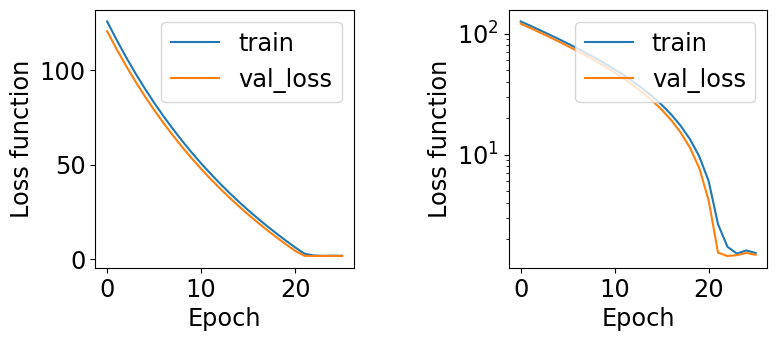

In [14]:
#BEGIN_SOLUTION
model = tf.keras.Sequential(layers = [tf.keras.layers.InputLayer(shape=(None, 1)),
    tf.keras.layers.SimpleRNN(1, activation='linear',
                            bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1)
                            )],
                            name="fib_generator")
#model.summary()

initial_learning_rate = 1E-3
nStepsPerEpoch = dataset.cardinality().numpy()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=nStepsPerEpoch*200,
                decay_rate=0.95,
                staircase=False)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='mape', metrics=[])

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       start_from_epoch=15,
                                                       patience=3, verbose=1)
callbacks = [early_stop_callback]

history = model.fit(dataset,
                    validation_data=dataset,
                    callbacks=callbacks,
                    epochs=1500, verbose=0)
model.evaluate(dataset)
plf.plotTrainHistory(history)
#END_SOLUTION
pass

**Proszę:**

* podać na wejście modelu ciąg
```
data = np.array([[[46368], [75025], [121393], [196418], [317811], [514229]]])
```
* podać **pięć ostatnich elementów**
* podać **dwa ostatnich elementy ciągu**
* we wszystkich przypadkach porównać wynik modelu z wartością oczekiwaną dla elementów ciągu Fibbonaciego

In [15]:
#BEGIN_SOLUTION
data = np.array([[[46368], [75025], [121393], [196418], [317811], [514229]]])
print(colored("Data:","blue"), data[0,:,0])
print(colored("Prediction:","blue"),model.predict(data)[0,0], end=" ")
print(colored("True value:","blue"),data[0,-1,0]+data[0,-2,0])

print(colored("Data:","blue"), data[0,1:,0])
print(colored("Prediction:","blue"),model.predict(data[:,1:,:])[0,0], end=" ")
print(colored("True value:","blue"),data[0,-1,0]+data[0,-2,0])

print(colored("Data:","blue"), data[0,-2:,0])
print(colored("Prediction:","blue"),model.predict(data[:,-2:,:])[0,0], end=" ")
print(colored("True value:","blue"),data[0,-1,0]+data[0,-2,0])
#END_SOLUTION
pass

Data: [ 46368  75025 121393 196418 317811 514229]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
Prediction: 835911.75 True value: 832040
Data: [ 75025 121393 196418 317811 514229]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
Prediction: 832778.56 True value: 832040
Data: [317811 514229]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Prediction: 730743.2 True value: 832040


Komórka RNN ma pewną wadę: wyjście jest średnią ważoną wejścia i stanu z poprzedniego kroku. To oznacza, że dane z odległych kroków w przeszłości mają mały wpływ na stan komórki w bieżącym kroku - komórka ma jedynie pamięć krótkotrwałą. Rozwiązaniem tego problemu jest wyposażenie komórki w dodatkowy stan ukryty, który może przechowywać dane w długim kresie czasu - pamięć długotrwałą. Komórka ma więc dwa rodzaje pamięci - krótko- i długo-trwałą, ang. `Long Short-Term Memory, LSTM`.




![image.png](attachment:1f3ccf4e-54de-4729-ad36-7bdf082c7131.png)

![image.png](attachment:037d00ee-7be7-4e17-8f84-0c5b05ac85f9.png)

![image.png](attachment:8933ecd1-85f2-448f-aacd-402436ff7e03.png)

![image.png](attachment:2967d114-718b-42d8-bd63-0b7519f64328.png)

![image.png](attachment:34e0cfaa-c56d-475c-9684-e8fd6dddd1af.png)

![image.png](attachment:f0e2f9b1-84cb-42c9-8683-b0025c31b167.png)

Implementacja komórki LSTM w Keras:
```Python
tf.keras.layers.LSTMCell(
    units,
    activation='tanh',
    recurrent_activation='sigmoid',
    use_bias=True,
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros',
    unit_forget_bias=True,
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    seed=None,
    **kwargs
)
```

**Proszę:**

* zbudować i wytrenować model z komórką RSTM który przewidzi następny element ciągu Fibonacciego na podstawie podanego ciągu - niekoniecznie dwuelementowego

**Wskazówki:**
* jak funkcja aktywacji jest odpowiednia dla wyjścia o wartości nieograniczonej z góry?
* trening jest niestabilny - trzeba go przeprowadzić kilkakrotnie

Epoch 1/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 100.9135 - val_loss: 100.1671
Epoch 2/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 100.5844 - val_loss: 100.1257
Epoch 3/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 100.4435 - val_loss: 100.0977
Epoch 4/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 100.3467 - val_loss: 100.0780
Epoch 5/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 100.2782 - val_loss: 100.0637
Epoch 6/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 100.2283 - val_loss: 100.0531
Epoch 7/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 100.1910 - val_loss: 100.0450
Epoch 8/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 100.1623 - val_loss: 100.0387
Epoch 9/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 100.1398 - val_loss: 100.0336
Epoch 10/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 100.1217 - val_loss: 100.0295
Epoch 11/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 100.1071 - val_loss: 100.0262
Epoch 12/500
25/25

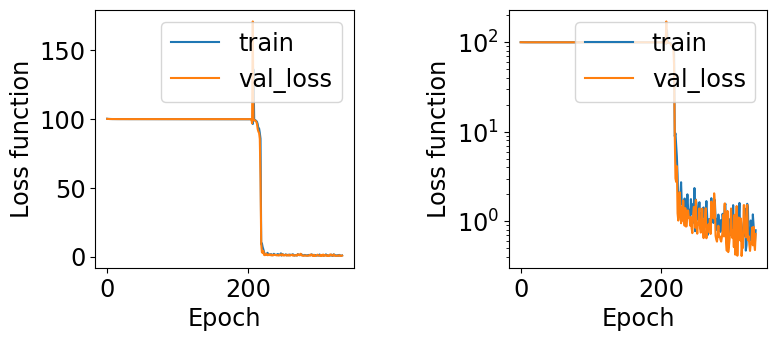

In [21]:

model = tf.keras.Sequential(layers = [tf.keras.layers.InputLayer(shape=(None, 1)),
    tf.keras.layers.LSTM(1, activation='linear',
                            bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1)
                            )],
                            name="fib_generator")

initial_learning_rate = 5E-3
nStepsPerEpoch = dataset.cardinality().numpy()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=nStepsPerEpoch*100,
                decay_rate=0.95,
                staircase=False)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='mape', metrics=[])

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       start_from_epoch=15,
                                                       patience=20, verbose=1)
callbacks = [early_stop_callback]

history = model.fit(dataset,
                    validation_data=dataset,
                    callbacks=callbacks,
                    epochs=500, verbose=1)
model.evaluate(dataset)
plf.plotTrainHistory(history)


**Proszę:**

* wypisać na ekran etykiety i efekt działania modelu

In [22]:
#BEGIN_SOLUTION
predictions = model.predict(dataset)[:,0].astype(int)
labels = fib_sequence[window_size-3:]

for label, prediction in zip(labels, predictions):
    print(colored("Label, prediction:","blue"), label, prediction)
#END_SOLUTION
pass

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Label, prediction: 8 7
Label, prediction: 13 12
Label, prediction: 21 20
Label, prediction: 34 33
Label, prediction: 55 54
Label, prediction: 89 88
Label, prediction: 144 144
Label, prediction: 233 234
Label, prediction: 377 381
Label, prediction: 610 618
Label, prediction: 987 997
Label, prediction: 1597 1608
Label, prediction: 2584 2597
Label, prediction: 4181 4197
Label, prediction: 6765 6786
Label, prediction: 10946 10976
Label, prediction: 17711 17754
Label, prediction: 28657 28721
Label, prediction: 46368 46466
Label, prediction: 75025 75178
Label, prediction: 121393 121636
Label, prediction: 196418 196806
Label, prediction: 317811 318434
Label, prediction: 514229 515232
Label, prediction: 832040 833657


**Proszę:**

* narysować panel z dwoma rysunkami:
   * X=model,  Y=etykieta
   * X=numer elementu, Y=model/etykieta

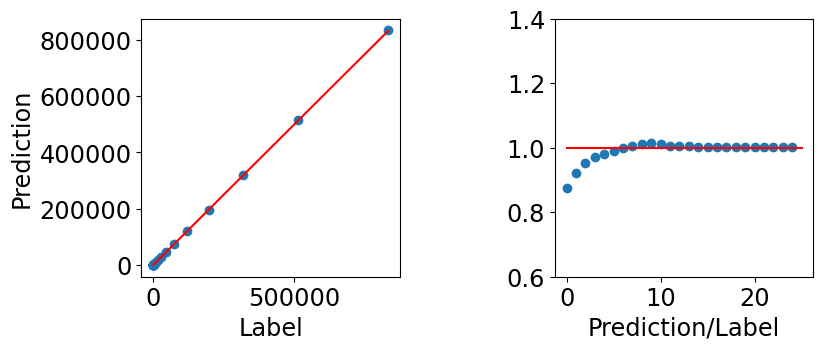

In [24]:

fig, axes = plt.subplots(1, 2, figsize=(7,3))

axes[0].plot(labels, predictions, 'o')
axes[0].plot([0,max(labels)], [0,max(labels)], 'r')
axes[0].set_xlabel("Label")
axes[0].set_ylabel("Prediction")

axes[1].plot(predictions/labels, 'o')
axes[1].plot([0,len(labels)], [1,1], 'r')
axes[1].set_xlabel("Prediction/Label")
axes[1].set_ylim([0.6,1.4])
plt.subplots_adjust(bottom=0.02, left=0.02, right=0.98, wspace=0.6)


**Proszę:**

* podać na wejście modelu ciąg
```
data = np.array([[[46368], [75025], [121393], [196418], [317811], [514229]]])
```
* podać ten sam ciąg, **pomijając pierwszy element**
* podać **dwa ostatnie elementy ciągu**
* we wszystkich przypadkach porównać wynik modelu z wartością oczekiwaną dla elementów ciągu Fibbonaciego

In [ ]:
#BEGIN_SOLUTION
data = np.array([[[46368], [75025], [121393], [196418], [317811], [514229]]])
print(colored("Data:","blue"), data[0,:,0])
print(colored("Prediction:","blue"),model.predict(data)[0,0], end=" ")
print(colored("True value:","blue"),data[0,-1,0]+data[0,-2,0])

print(colored("Data:","blue"), data[0,1:,0])
print(colored("Prediction:","blue"),model.predict(data[:,1:,:])[0,0], end=" ")
print(colored("True value:","blue"),data[0,-1,0]+data[0,-2,0])

print(colored("Data:","blue"), data[0,-2:,0])
print(colored("Prediction:","blue"),model.predict(data[:,-2:,:])[0,0], end=" ")
print(colored("True value:","blue"),data[0,-1,0]+data[0,-2,0])
#END_SOLUTION
pass

Data: [ 46368  75025 121393 196418 317811 514229]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Prediction: 833804.2 True value: 832040
Data: [ 75025 121393 196418 317811 514229]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Prediction: 832507.4 True value: 832040
Data: [317811 514229]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Prediction: 762154.75 True value: 832040


# Zadanie domowe

**Proszę:**

* napisać generator `generateWave()` generującą ciągi liczb `(y)` o losowej długości w zakresie `[10, 100]` elementów
    * wartości `y` to `sin(x)`
    * wartości `x` zaczynają się od losowej liczby w zakresie `[0, $2\pi$]` i zwiększają kolejno o `0.01`
* stworzyć zbiór `tf.data.Dataset` korzystając z  generatora `generateWave()`
* podzielić wiersze zbioru na cechy: `[:-3]` i etykiety: [-1]
* wypisać na ekran pierwsze `5` przykładów
* podzielić zbiór na paczki o rozmiarze dopuszczalnym przez oprogramowanie.
  Napisać komentarz uzasadniający rozmiar paczki
* przygotować `nBatches = 8192` paczek
  

* przeprowadzić trening modelu LSTM przewidującego wartość ostatniego elementu ciągu na podstawie wcześniejszych `[:-3]` elementów sekwensji

* narysować rysunek z trzema polami:
  * prawdziwa wartość: `y`, przewidziana wartość: `y_pred`,
    wartość przed ostatniego elementu zwrócona jako wartość następnego elementu: `y_naive`
  * stosunki `(y-y_pred)/y`, `(y_naive-y)/y` (na jednym rysunku)
  * histogramy `(y-y_pred)/y`, `(y_naive-y)/y` (na jednym rysunku)
* w czasie rysowania zwrócić uwagę na synchronizację elementów `y` i `y_pred`

* `y_pred` obliczyć na podstawie coraz dłużych sekwencji zawierających wszystkie elementy od wartości `0` to aktualnej wartości `x`, począwszy od sekwencji o długości `1`.

In [ ]:
# data generattion
nBatches = 8192
batchSize = 1

#BEGIN_SOLUTION
def generateWave():
    minN = 10
    maxN = 100
    step = 0.01
    while True:
        length = np.random.randint(minN, maxN)
        offset = np.random.default_rng().uniform(0, 2*np.pi)
        x = np.linspace(offset, offset+step*length, length)
        yield np.sin(x)
        #yield 0.3*np.sin(5*x) + 0.7*cos(x)

# dataset from generator
dataset = tf.data.Dataset.from_generator(generateWave, output_signature=tf.TensorSpec(shape=(None,), dtype=tf.float64))

# features, labels split
dataset = dataset.map(lambda x: (x[:-3], x[-1]))


# print first 5 elements
for item in dataset.take(5):
    print(colored("Features:","blue"), item[0].numpy(), end=" ")
    print(colored("Labels:","blue"), item[1].numpy())

# batch, set number of examples and cache
dataset = dataset.batch(batchSize).take(nBatches).cache()

print(colored("Comment on batch size:","blue"),
      "Since the length of the sequences is variable, the batch size has to be set to 1 in ordfer not to mix sequences of different length.")

#END_SOLUTION
pass

Features: [0.72662236 0.73357347 0.74044867 0.74724726 0.75396852 0.76061176
 0.76717629 0.77366144 0.78006654 0.78639091 0.79263392 0.7987949
 0.80487322 0.81086826 0.8167794  0.82260601 0.8283475  0.83400328
 0.83957276 0.84505536 0.85045052 0.85575768 0.86097628 0.8661058
 0.87114569 0.87609544 0.88095453 0.88572246 0.89039874 0.89498289
 0.89947442 0.90387288 0.90817781 0.91238877 0.91650531 0.92052702
 0.92445347 0.92828426 0.932019   0.93565729 0.93919877 0.94264306
 0.9459898  0.94923866 0.9523893  0.95544138 0.9583946  0.96124864
 0.96400322 0.96665805 0.96921285 0.97166735 0.97402132 0.97627449
 0.97842664 0.98047755] Labels: 0.9860207288340171
Features: [0.94855471 0.95172723 0.9548012  0.95777632 0.96065227 0.96342876
 0.96610549 0.9686822  0.97115861 0.97353446 0.97580952 0.97798354
 0.98005631 0.9820276  0.98389721 0.98566496 0.98733064 0.9888941
 0.99035518 0.99171371 0.99296956 0.9941226  0.99517271 0.99611978
 0.99696372 0.99770443 0.99834184 0.99887588 0.9993065  0.999

2024-06-06 12:52:17.996850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11.2 µs


Model: "wave_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 1)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

2024-06-06 12:53:04.884933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-06-06 12:53:04.884969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-06 12:53:09.387667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-06 12:53:09.387696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is abortin

      1/Unknown 0s 14ms/step - loss: 2.2767e-04

2024-06-06 13:27:11.921537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-06 13:27:11.921560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-06 13:27:12.059772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-06 13:27:12.059798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


8192/8192 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 3.5784e-04


2024-06-06 13:27:21.303060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-06 13:27:21.303084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


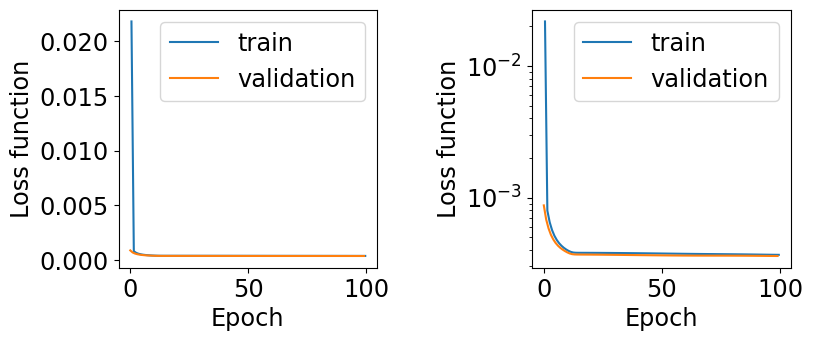

In [ ]:
%time
# model definition and training
#BEGIN_SOLUTION
model = tf.keras.Sequential(layers = [tf.keras.layers.InputLayer(shape=(None, 1)),
    tf.keras.layers.LSTM(1, activation='linear',
                            bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1)
                            )],
                            name="wave_generator")
model.summary()

initial_learning_rate = 1E-3
nStepsPerEpoch = nBatches
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=nStepsPerEpoch*100,
                decay_rate=0.95,
                staircase=False)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='mse', metrics=[])

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       start_from_epoch=15,
                                                       patience=20, verbose=1)
callbacks = [early_stop_callback]

history = model.fit(dataset.skip(128),
                    validation_data=dataset.take(128),
                    callbacks=callbacks,
                    epochs=100, verbose=0)
model.evaluate(dataset)
plf.plotTrainHistory(history)
#END_SOLUTION
pass

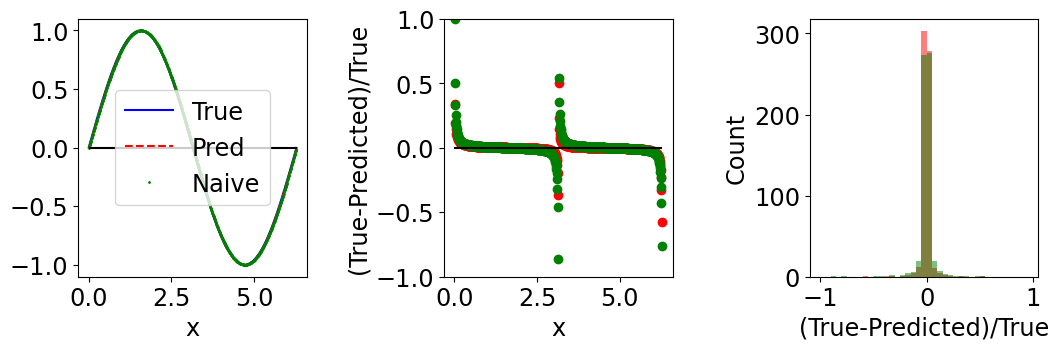

In [ ]:
# control plots
#BEGIN_SOLUTION
fig, axes = plt.subplots(1, 3, figsize=(10,3))

maxX = 2*np.pi
x = np.arange(0, maxX, 0.01)
y = np.sin(x)
# the model is just a bit better than naive one
# other functions also suprinsingly work well
#y = 1/3*(np.sin(5*x)+2*np.sin(2*x))
#y = x**2/40
#except for a linear one :)
#y=x
###
y_pred = [model.predict(y[:index].reshape(1,-1,1), verbose=0)[0,0] for index in range(1,len(x))]
y_naive = np.roll(y, 1)

axes[0].plot(x,y, 'b', label="True")
axes[0].plot(x[1:],y_pred, 'r--', label="Pred")
axes[0].plot(x[1:],y_naive[1:], 'go', markersize="1", label="Naive")
axes[0].hlines(0, 0, maxX, 'k')
#axes[0].set_xlim([0, 0.5])
axes[0].set_xlabel("x")
axes[0].set_ylabel("")
axes[0].legend()

axes[1].plot(x[1:],(y[1:]-y_pred)/y[1:], 'or')
axes[1].plot(x[1:],(y[1:]-y_naive[1:])/y[1:], 'og')
axes[1].hlines(0, 0, maxX, 'k')
axes[1].set_ylim([-1, 1])
axes[1].set_xlabel("x")
axes[1].set_ylabel("(True-Predicted)/True")

# additional plot, not requested in the task
axes[2].hist((y[1:]-y_pred)/y[1:], color='r', alpha=0.5, bins=np.arange(-1,1,0.05))
axes[2].hist((y[1:]-y_naive[1:])/y[1:], color='g', alpha=0.5, bins=np.arange(-1,1,0.05))
axes[2].set_xlabel("(True-Predicted)/True")
axes[2].set_ylabel("Count")

plt.subplots_adjust(bottom=0.02, left=0.02, right=0.98, wspace=0.6)
#END_SOLUTION
pass